# DELE CA2: Double Dueling Deeq-Q Learning

> This notebook is dedicated to running the D3QN algorithm on the LunarLanderV2 environment and render a video of the spacecraft lander on the landing pad.

In [1]:
# Import Libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
import os
import time
import datetime
import tensorflow.keras as keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

## Replay Buffer and Experience Replay

> A buffer (temporary memory) of observations, rewards, and subsequent observations. The buffer is used to then train the Deep Learning model. 

The purpose of Experience Replay is to store past experiences and then using a random subset of these experiences to update the Q-network, rather than using just the single recent experience.

A replay buffer contains a collection of experience (State, Action, Reward, New State). Normally, a replay buffer is store as a queue, where new buffer is added to the end so that it pushes the oldest experience out of it.

In [2]:
# The ReplayBuffer class is used to store experiences in a buffer of size N. 
# The buffer is used to sample a batch of experiences from the buffer to train the agent.
class ReplayBuffer:
    def __init__(self, size, input_shape):
        self.size = size
        self.counter = 0
        self.state_buffer = np.zeros((self.size, *input_shape), dtype=np.float32)
        self.action_buffer = np.zeros(self.size, dtype=np.int32)
        self.reward_buffer = np.zeros(self.size, dtype=np.float32)
        self.new_state_buffer = np.zeros((self.size, *input_shape), dtype=np.float32)
        self.terminal_buffer = np.zeros(self.size, dtype=np.bool_)

    # insert experience into the buffer
    def store_tuples(self, state, action, reward, new_state, done):
        idx = self.counter % self.size
        self.state_buffer[idx] = state
        self.action_buffer[idx] = action
        self.reward_buffer[idx] = reward
        self.new_state_buffer[idx] = new_state
        self.terminal_buffer[idx] = done
        self.counter += 1

    # Sample a batch of experiences from the buffer
    def sample_buffer(self, batch_size):
        max_buffer = min(self.counter, self.size)
        batch = np.random.choice(max_buffer, batch_size, replace=False)
        state_batch = self.state_buffer[batch]
        action_batch = self.action_buffer[batch]
        reward_batch = self.reward_buffer[batch]
        new_state_batch = self.new_state_buffer[batch]
        done_batch = self.terminal_buffer[batch]

        return state_batch, action_batch, reward_batch, new_state_batch, done_batch

## Double Dueling DQN

The double dueling DQN is pretty similar to the Dueling DQN, there are two consisting estimator - the state value function, and the state dependent action advantage function.

However there is an issue of a single DQN. The first time an agent receives a positive reward, it might continue making the same set action. A solution to solve this problem is to use two action value functions, in other words, two lookup tables. The agent uses one to update the other Q-value, providing an unbiased estimate of Q(s, a).

In [3]:
# The Dueling Double Deep Q Network is a neural network that has two separate heads. 
# One head is for the state value function V(s) and the other is for the advantage function A(s,a). 
# The advantage function is the difference between the state value function and the average of the
# advantage function. 
# The advantage function is used to reduce the overestimation of the Q function.
class DuelingDoubleDeepQNetwork(keras.Model):
    def __init__(self, num_actions, fc1, fc2):
        super(DuelingDoubleDeepQNetwork, self).__init__()
        self.dense1 = Dense(fc1, activation='relu')
        self.dense2 = Dense(fc2, activation='relu')
        self.V = Dense(1, activation=None)
        self.A = Dense(num_actions, activation=None)

    def call(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        V = self.V(x)
        A = self.A(x)
        avg_A = tf.math.reduce_mean(A, axis=1, keepdims=True)
        Q = (V + (A - avg_A))

        return Q, A

# Agent

## Target Network

> A target network is a copy of the estimated value function that is held fixed to serve as a stable target for some number of steps.

When we alter the neural network parameters to $Q(s,a)$, it make alter $Q(s',a')$ and other states nearby, which is determined to make training very unstable.

To make training more stabel, copying over the Q Net over to the target network and use it for the $Q(s', a')$. 

## Policy

The policy takes the highest Q-value of the current state and chooses the action with the highest Q-value. For the first few episodes, the agent will explore the environment by randomly choosing actions.

$a \leftarrow argmax\ Q(s, a_s)$


In [4]:
# Agent Class
class Agent:
    def __init__(self, lr, discount_factor, num_actions, epsilon, batch_size, input_dim):
        self.action_space = [i for i in range(num_actions)]
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.epsilon_decay = 0.001
        self.epsilon_final = 0.01
        self.update_rate = 120
        self.step_counter = 0
        self.buffer = ReplayBuffer(100000, input_dim)
        self.q_net = DuelingDoubleDeepQNetwork(num_actions, 128, 128)
        self.q_target_net = DuelingDoubleDeepQNetwork(num_actions, 128, 128)
        self.q_net.compile(optimizer=Adam(learning_rate=lr), loss='mse')
        self.q_target_net.compile(optimizer=Adam(learning_rate=lr), loss='mse')

    def store_tuple(self, state, action, reward, new_state, done):
        '''
        Store the tuple of the experience in the buffer.
        
        state: The state of the environment before the agent took the action
        action: The action taken by the agent in the current state
        reward: The reward received for performing action in state
        new_state: The state the agent is in after performing the action
        done: A boolean that indicates whether the episode has finished
        '''
        self.buffer.store_tuples(state, action, reward, new_state, done)

    def policy(self, observation):
        # Explores the env using random actions in the first few episodes
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            # Picks the action with the highest Q value
            state = np.array([observation])
            _, actions = self.q_net(state)
            action = tf.math.argmax(actions, axis=1).numpy()[0]

        return action

    def train(self):
        '''
        Update the Q-network by training on a batch sampled from the replay buffer
        return: The agent's behaviour.
        '''
        # If the replay buffer is less than the batch size, don't train
        if self.buffer.counter < self.batch_size:
            return
        
        # This is the code that updates the target network. The target network is updated every 120 steps.
        if self.step_counter % self.update_rate == 0:
            self.q_target_net.set_weights(self.q_net.get_weights())

        # Sample a batch of experiences from the replay buffer
        state_batch, action_batch, reward_batch, new_state_batch, done_batch = \
            self.buffer.sample_buffer(self.batch_size)

        # Get the Q values for the next state and the action taken
        q_predicted, _ = self.q_net(state_batch)
        q_next, _ = self.q_target_net(new_state_batch)
        q_target = q_predicted.numpy()
        _, actions = self.q_net(new_state_batch)
        max_actions = tf.math.argmax(actions, axis=1)

        for idx in range(done_batch.shape[0]):
            q_target[idx, action_batch[idx]] = reward_batch[idx] + self.discount_factor*q_next[idx, max_actions[idx]] *\
                                               (1-int(done_batch[idx]))

        # Train the network over state and Q Target
        self.q_net.train_on_batch(state_batch, q_target)
        self.epsilon = self.epsilon - self.epsilon_decay if self.epsilon > self.epsilon_final else self.epsilon_final
        self.step_counter += 1
    
    # Main Function to train D3QN
    def train_model(self, env, num_episodes, graph):
        scores, episodes, avg_scores, obj = [], [], [], []
        goal = 200
        f = 0
        txt = open("saved_networks.txt", "w")

        # This is the code that is used to train the agent. The agent is trained for a number of episodes.
        for i in range(num_episodes):
            done = False
            score = 0.0
            state = env.reset()
            while not done:
                action = self.policy(state)
                new_state, reward, done, _ = env.step(action)
                score += reward
                self.store_tuple(state, action, reward, new_state, done)
                state = new_state
                self.train()
            scores.append(score)
            obj.append(goal)
            episodes.append(i)
            avg_score = np.mean(scores[-100:])
            avg_scores.append(avg_score)
            print("Episode {0}/{1}, Score: {2} ({3}), AVG Score: {4}".format(i, num_episodes, score, self.epsilon,
                                                                             avg_score))
            
            # Saves the network's weights when avg score larger than 200 and score larger than 250
            if avg_score >= 200.0 and score >= 250:
                self.q_net.save(("saved_networks/d3qn_model{0}".format(f)))
                self.q_net.save_weights(("saved_networks/d3qn_model{0}/net_weights{0}.h5".format(f)))
                txt.write("Save {0} - Episode {1}/{2}, Score: {3} ({4}), AVG Score: {5}\n".format(f, i, num_episodes,
                                                                                                  score, self.epsilon,
                                                                                                  avg_score))
                f += 1
                print("Network saved")

        txt.close()
        
        
        # Creating Training Learning Curve
        if graph:
            df = pd.DataFrame({'x': episodes, 'Score': scores, 'Average Score': avg_scores, 'Solved Requirement': obj})

            with plt.style.context('ggplot'):
                fig, ax = plt.subplots(figsize=(16, 9))
                ax.plot('x', 'Score', data=df, marker='', color='blue', linewidth=2, label='Score')
                ax.plot('x', 'Average Score', data=df, marker='', color='orange', linewidth=2, linestyle='dashed',
                        label='AverageScore')
                ax.plot('x', 'Solved Requirement', data=df, marker='', color='red', linewidth=2, linestyle='dashed',
                        label='Solved Requirement')
                ax.legend()
                fig.savefig('Train Learning Curve.png')

    # Main Function to test the trained D3QN on a rendered env
    def test(self, env, num_episodes, file_type, file, graph):
        # Loading the D3QN weights from the saved model
        if file_type == 'tf':
            self.q_net = tf.keras.models.load_model(file)
        elif file_type == 'h5':
            self.train_model(env, 5, False)
            self.q_net.load_weights(file)
        self.epsilon = 0.0
        scores, episodes, avg_scores, obj = [], [], [], []
        goal = 200
        score = 0.0
        for i in range(num_episodes):
            state = env.reset()
            done = False
            episode_score = 0.0
            while not done:
                env.render()
                action = self.policy(state)
                new_state, reward, done, _ = env.step(action)
                episode_score += reward
                state = new_state
            score += episode_score
            scores.append(episode_score)
            obj.append(goal)
            episodes.append(i)
            avg_score = np.mean(scores[-100:])
            avg_scores.append(avg_score)
            
            print("Episode {0}/{1}, Score: {2} ({3}), AVG Score: {4}".format(i, num_episodes, episode_score, self.epsilon,
                                                                    avg_score))

        # Create Test Learning Curve
        if graph:
            df = pd.DataFrame({'x': episodes, 'Score': scores, 'Average Score': avg_scores, 'Solved Requirement': obj})

            with plt.style.context('ggplot'):
                fig, ax = plt.subplots(figsize=(16, 9), tight_layout=True)
                ax.plot('x', 'Score', data=df, marker='', color='blue', linewidth=2, label='Score')
                ax.plot('x', 'Average Score', data=df, marker='', color='orange', linewidth=2, linestyle='dashed',
                        label='AverageScore')
                ax.plot('x', 'Solved Requirement', data=df, marker='', color='red', linewidth=2, linestyle='dashed',
                        label='Solved Requirement')
                ax.legend()
                fig.savefig('D3QN Test Learning Curve.png')

        env.close()

In [5]:
# Creating the environment and setting the specs for the environment
env = gym.make("LunarLander-v2")
spec = gym.spec("LunarLander-v2")
monitor = gym.wrappers.Monitor(env, './D3QN_videos/', force=True)
num_episodes = 100
graph = True
file_type = 'tf'
file = 'saved_networks/d3qn_model133'

# creating instance of the Agenet Class
dqn_agent = Agent(lr=0.00075, discount_factor=0.99, num_actions=4, epsilon=1.0, batch_size=64, input_dim=[8])

Episode 0/100, Score: 264.8292537936755 (0.0), AVG Score: 264.8292537936755
Episode 1/100, Score: 267.83218303031344 (0.0), AVG Score: 266.33071841199444
Episode 2/100, Score: 274.98190803184144 (0.0), AVG Score: 269.2144482852768
Episode 3/100, Score: 279.7714198823496 (0.0), AVG Score: 271.85369118454497
Episode 4/100, Score: 58.72980726897518 (0.0), AVG Score: 229.22891440143104
Episode 5/100, Score: 303.9199629189393 (0.0), AVG Score: 241.6774224876824
Episode 6/100, Score: 268.8150589238494 (0.0), AVG Score: 245.5542276928491
Episode 7/100, Score: 276.28354311404314 (0.0), AVG Score: 249.39539212049834
Episode 8/100, Score: 258.5257785426428 (0.0), AVG Score: 250.40987950073662
Episode 9/100, Score: 293.76683083482425 (0.0), AVG Score: 254.74557463414538
Episode 10/100, Score: 280.87360151260964 (0.0), AVG Score: 257.1208498049149
Episode 11/100, Score: 275.15142223714645 (0.0), AVG Score: 258.6233975076008
Episode 12/100, Score: 257.60096329052675 (0.0), AVG Score: 258.5447487216

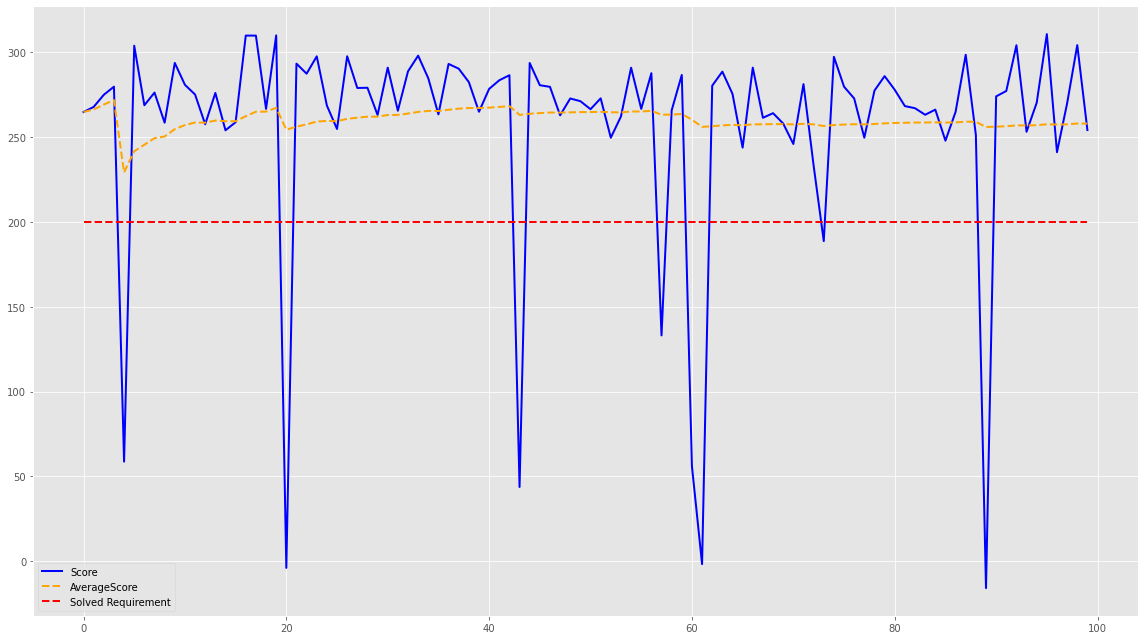

In [6]:
%%time
# Traing D3QN Agent
dqn_agent.test(monitor, num_episodes, file_type, file, graph)